In [1]:
from astropy.io import fits
from astropy import units as u
import numpy as np
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
from astropy.wcs import WCS
# specutils packages
from specutils import Spectrum1D
from specutils.analysis import line_flux
from specutils.fitting import fit_generic_continuum
from specutils.fitting import find_lines_threshold
from specutils import SpectralRegion
from specutils.analysis import equivalent_width
from specutils.analysis import centroid
from specutils.analysis import moment
from specutils.manipulation import extract_region
from specutils.fitting import find_lines_derivative
from scipy.signal import find_peaks
import seaborn as sns
import warnings
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7fe0b43e4610>

In [2]:
hdu = fits.open("comb_PNc2_M1.fits")
hdu.info()

Filename: comb_PNc2_M1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     357   (2030, 819)   float32   


In [3]:
hdu[0].header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 2030 / Axis length                                    
NAXIS2  =                  819 / Axis length                                    
EXTEND  =                    T / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
IRAF-TLM= '2023-08-03T18:11:51' / Time of last modification                     
OBJECT  = 'PNc2_M1 '           / Name of the object observed                    
DATE-OBS= '2022-01-26T02:40:11.444' / DATE-OBS Format: YYYY-MM-DDThh:mm:ss.sss  
DATE    = '2023-08-03T18:11:51' / Date Format is YYYY-MM-DD                     
TIME    = '02:40:11.444 to 02:58:11.447' / ~ Start & Stop of Exposure           
N_PRM0  =                   

In [4]:
hdudata = hdu[0].data
hdudata 

array([[-1.8023755e-14, -1.7051958e-13,  3.4835985e-14, ...,
         3.9878544e-16,  3.9958644e-16,  3.9887692e-16],
       [-1.1982414e-13, -7.4279497e-14,  1.5079651e-14, ...,
         3.3951534e-16,  3.4031912e-16,  3.3961241e-16],
       [-8.8554686e-15, -7.1835028e-14,  3.3158958e-14, ...,
         2.1777691e-16,  2.1858651e-16,  2.1788562e-16],
       ...,
       [ 6.1808024e-13,  5.8354493e-13,  6.1736553e-13, ...,
        -9.4684850e-18, -8.6567553e-18, -8.7327980e-18],
       [ 1.0219270e-12,  9.5897997e-13,  1.0404154e-12, ...,
        -1.1746105e-17, -8.2222779e-18, -8.5326460e-18],
       [ 1.0451585e-12,  9.8057185e-13,  1.1065250e-12, ...,
        -8.6541125e-18, -9.0081003e-18, -8.6272291e-18]], dtype=float32)

In [5]:
hdudata[442]

array([7.4544090e-14, 7.8230784e-14, 7.5957917e-14, ..., 1.7227347e-17,
       1.6513509e-17, 1.7747541e-17], dtype=float32)

In [6]:
nx, wav0, i0, dwav = [hdu[0].header[k] for k in ("NAXIS1", "CRVAL1", "CRPIX1", "CD1_1")]
wavs = wav0 + (np.arange(nx) - (i0 - 1))*dwav 

In [7]:
Flux = []
for i in range(406, 441):
    Flux.append(hdudata[i])
#Flux = hdudata
Flux_arr = np.array(Flux)
#Flux /= 1e-13

In [8]:
# Calculate the sum of elements across all rows (sum along axis 0)
Flux_sum = np.sum(Flux_arr, axis=0)
Flux_sum_= Flux_sum/1e-14

(-0.01, 2.0)

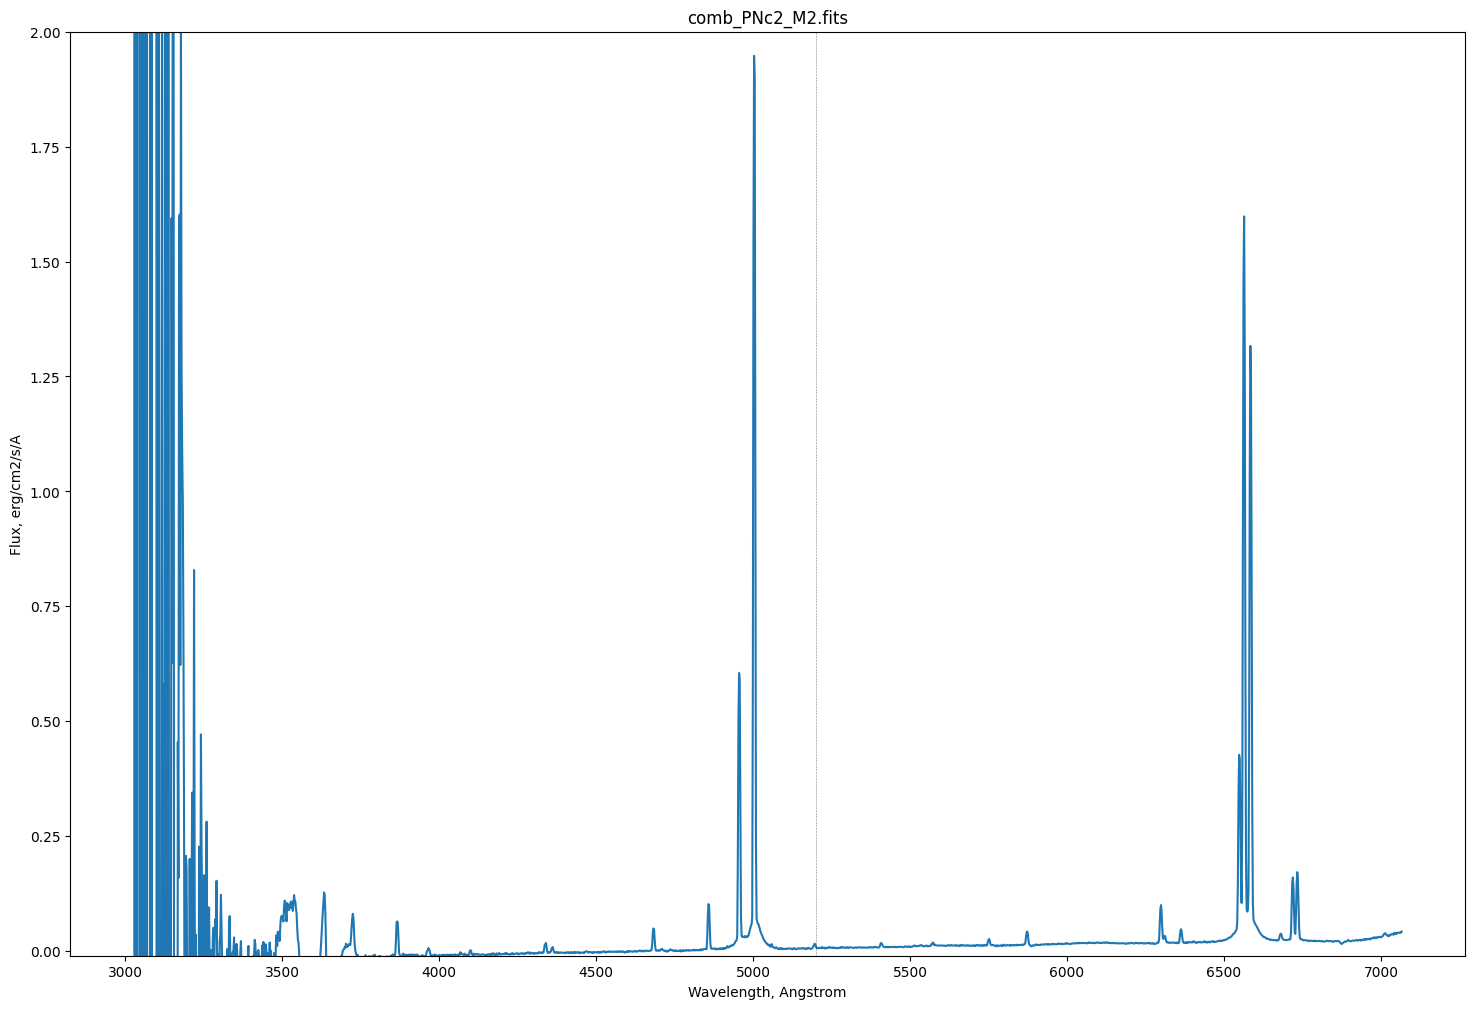

In [9]:
f, ax = plt.subplots(figsize=(18,12))  
ax.plot(wavs, Flux_sum_) 
ax.axvline(5200., color='k', linewidth=0.4, alpha=0.5, linestyle='--')
plt.title("comb_PNc2_M2.fits")
plt.xlabel("Wavelength, Angstrom")
plt.ylabel("Flux, erg/cm2/s/A")
#plt.xlim(xmin=5140,xmax=5265)
plt.ylim(ymin=-0.01,ymax=2) 

(-0.01, 1.8)

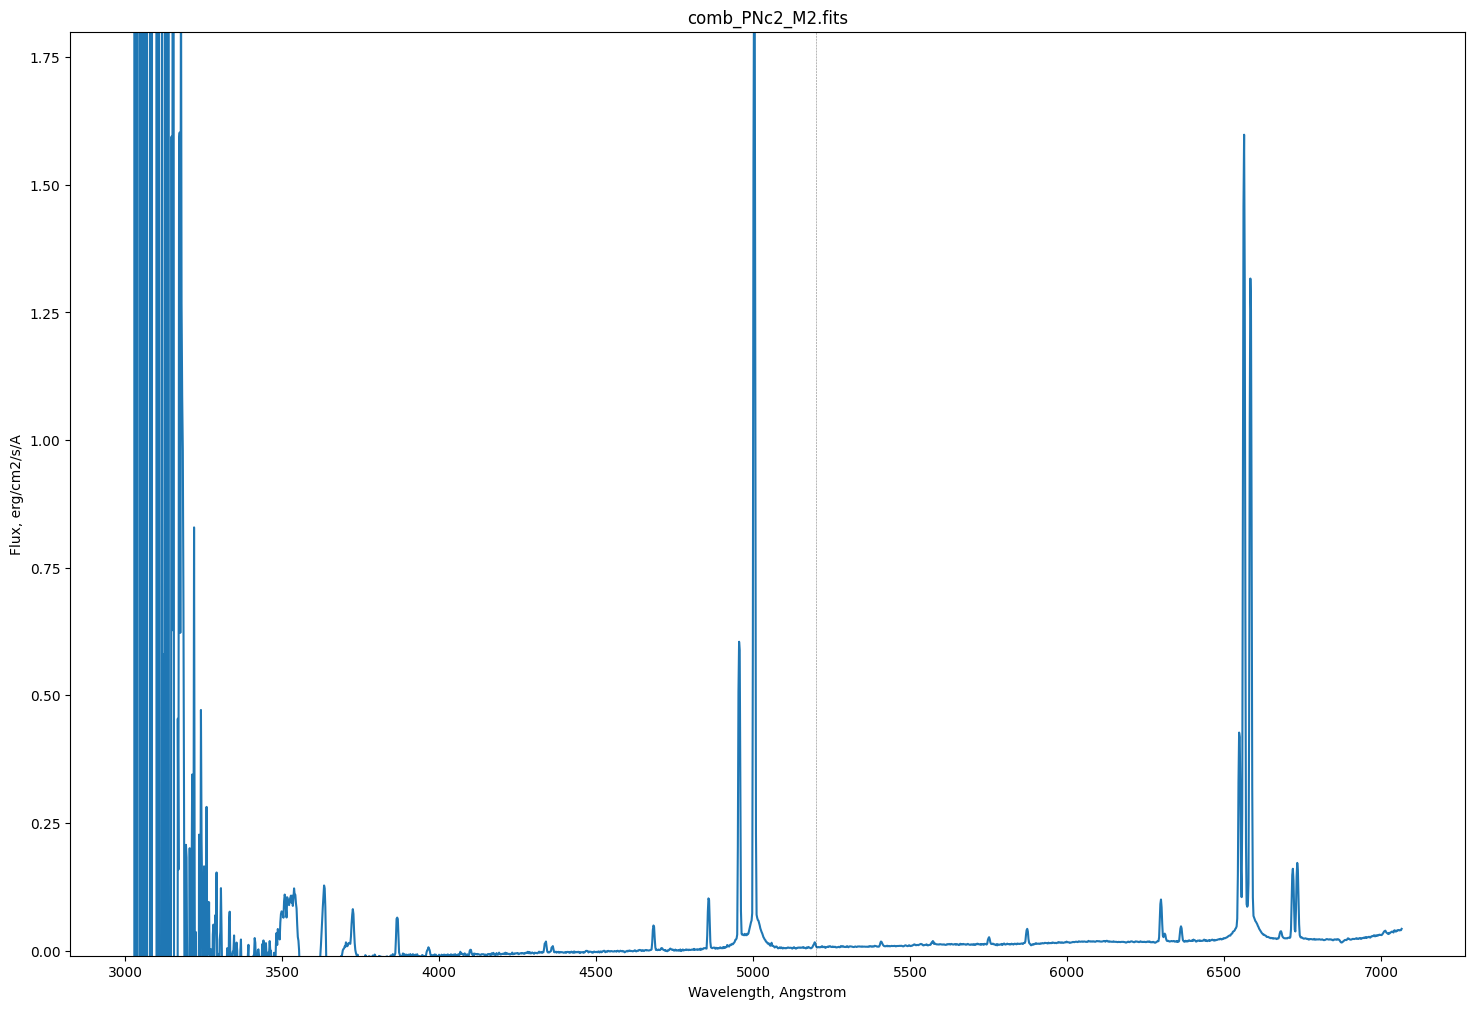

In [29]:
f, ax = plt.subplots(figsize=(18,12))  
ax.plot(wavs, Flux_sum_) 
ax.axvline(5200., color='k', linewidth=0.4, alpha=0.5, linestyle='--')
plt.title("comb_PNc2_M2.fits")
plt.xlabel("Wavelength, Angstrom")
plt.ylabel("Flux, erg/cm2/s/A")
#plt.xlim(xmin=5140,xmax=5265)
plt.ylim(ymin=-0.01,ymax=1.8) 

In [11]:

spec = Spectrum1D(flux=Flux_sum*u.Unit('erg cm-2 s-1 AA-1') , spectral_axis=wavs*u.AA)
sub_region = SpectralRegion(3700*u.AA, 7300*u.AA)
sub_spec = extract_region(spec, sub_region)
# Subtracting the continuum
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
    g1_fit = fit_generic_continuum(sub_spec )
y_continuum_fitted = g1_fit(sub_spec.spectral_axis)
spec_sub = sub_spec - y_continuum_fitted

In [12]:
#Spliting the spectrum en blue and red part
sub_region_blue = SpectralRegion(3700*u.AA, 5100*u.AA)
sub_region_red = SpectralRegion(5100*u.AA, 7300*u.AA)
sub_spectrum_blue = extract_region(spec_sub, sub_region_blue)
sub_spectrum_red = extract_region(spec_sub, sub_region_red)

In [13]:
lines_blue = find_lines_derivative(sub_spectrum_blue, flux_threshold=-0.1e-16)
lines_blue

line_center,line_type,line_center_index
Angstrom,,
float64,str10,int64
3710.8858494949295,emission,5
...,...,...
5092.766301889416,absorption,699


In [14]:
lines_red = find_lines_derivative(sub_spectrum_red, flux_threshold=-1.3e-16)
lines_red

line_center,line_type,line_center_index
Angstrom,,
float64,str10,int64
5196.3077767086,emission,48
...,...,...
7058.063141245841,absorption,983


In [15]:
#Mask emission
mask_blue = lines_blue["line_type"] == "emission"
lines_emiss_blue = lines_blue[mask_blue]
lines_emiss_blue 

line_center,line_type,line_center_index
Angstrom,,
float64,str10,int64
3710.8858494949295,emission,5
...,...,...
5003.1631025266615,emission,654


In [16]:
mask_red = lines_red["line_type"] == "emission"
lines_emiss_red = lines_red[mask_red]

(-0.1, 2.5)

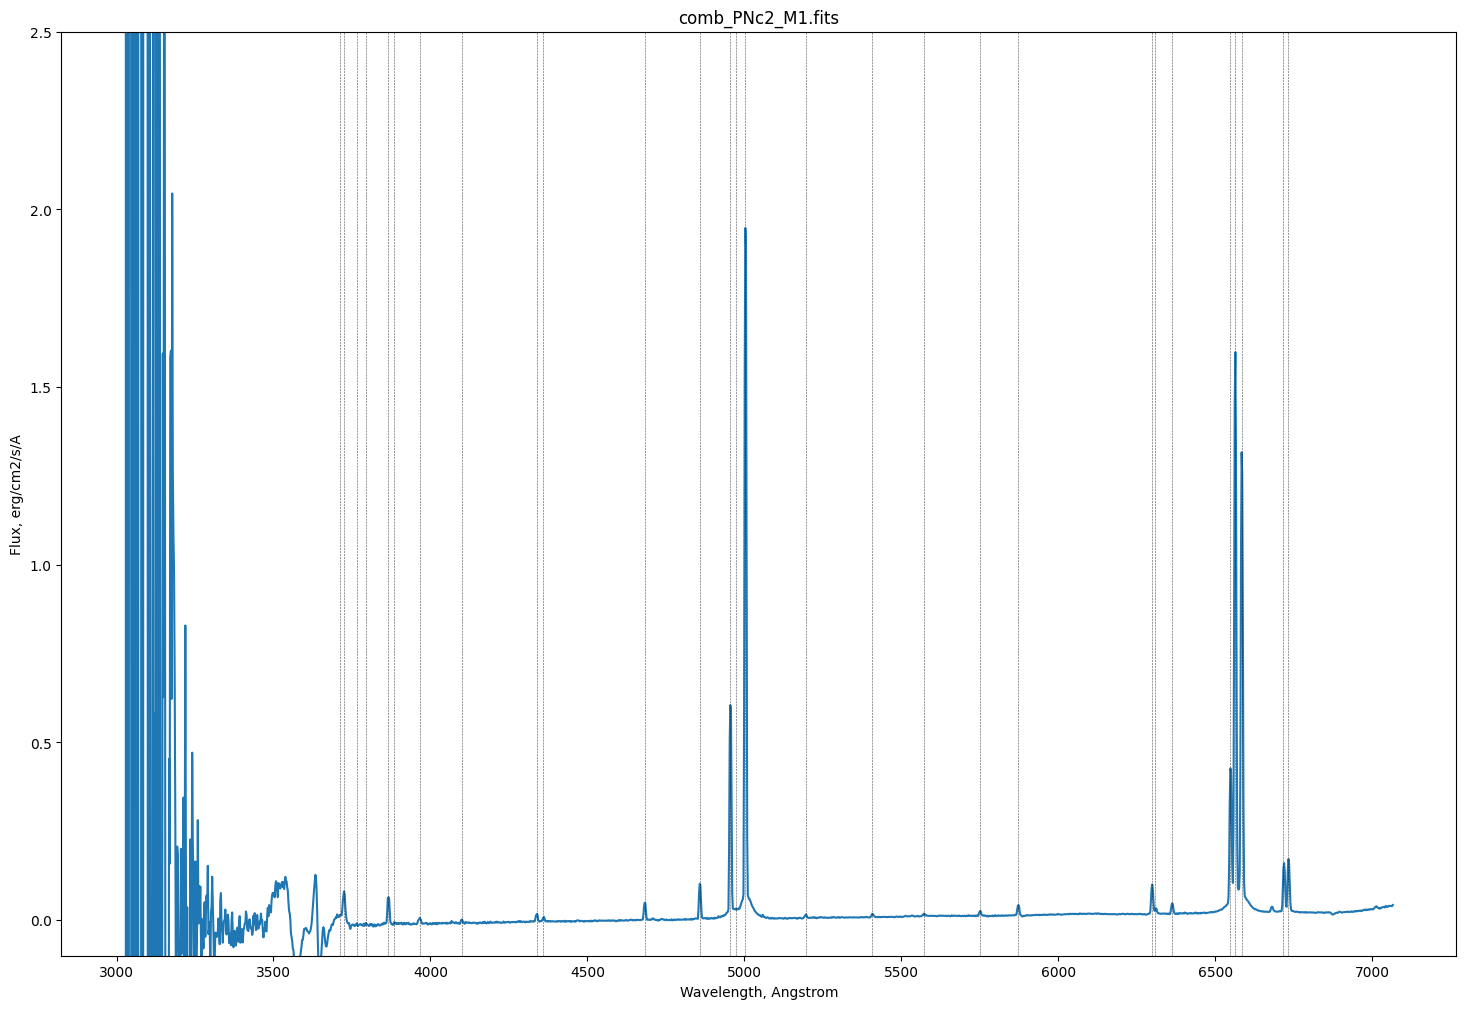

In [17]:
f, ax = plt.subplots(figsize=(18,12))  
plt.plot(wavs, Flux_sum_)
for wll in lines_emiss_blue["line_center"]:
    ax.axvline(wll, color='k', linewidth=0.4, alpha=0.7, linestyle='--')
for wll in lines_emiss_red["line_center"]:
    ax.axvline(wll, color='k', linewidth=0.4, alpha=0.7, linestyle='--')
plt.title("comb_PNc2_M1.fits")
plt.xlabel("Wavelength, Angstrom")
plt.ylabel("Flux, erg/cm2/s/A")
#plt.xlim(xmin=5140,xmax=5265)
plt.ylim(ymin=-0.1,ymax=2.5) 

## Pnc2_M2

In [25]:
hdu1 = fits.open("comb_PNc2_M2.fits")
nx, wav0, i0, dwav = [hdu1[0].header[k] for k in ("NAXIS1", "CRVAL1", "CRPIX1", "CD1_1")]
wavs1 = wav0 + (np.arange(nx) - (i0 - 1))*dwav 

In [19]:
def file_name(namefile, rowi, rowf, xlim=None, ylim=None):
    # Emission lines
    wv_lin = [3869.76, 3967.46, 4101.74, 4148.75, 4340.471, 4544, 4649.37, 4685, 4711.26, 4740.120, 4861.33, 
              4958.911, 5006.843, 5200.260, 5411.52, 6562.82, 6879, 7005.87, 7113.040, 7135, 7751, 8236.79, 8997.99]
    #em_lin = [r"[Ne III]" + "\n" + "3869", "[Ne III] + H7" + "\n" + "3968", r"H$\delta$", r"H$\gamma$", "He II", "He II", "[Ar IV]" + "\n" + "4711", "[Ar IV]" + "\n" + "4740", r"H$\beta$", "[O III]" + "\n" + "4958", "[O III]" + "\n" + "5007", "He II" + "\n" + "5411", "[N II]", r"H$\alpha$", "[N II]", "[S II]" + "\n" + "6731", "[Ar V]" + "\n" + "7005", "?" + "\n" + "7113", "[Ar III]" + "\n" + "7135", "[Ar III]" + "\n" + "7751", "He II" + "\n" + "8236", "[S III]" + "\n" + "9069"]

    em_lin = [r"[Ne III] 3869", "[Ne III] + H7 3968", r"H$\delta$", "Fe III 4149?", r"H$\gamma$", r"Ne II 4544?", 
              "Ne II 4649?", "He II 4685", "[Ar IV] 4711", "[Ar IV] 4740", r"H$\beta$", "[O III] 4958", "[O III] 5007", "5200.260", "[Fe III] 5412 or He II 5412",  r"H$\alpha$", "? 6879", "[Ar V] 7005", "C II 7113?", "[Ar III] 7135", "[Ar III] 7751", "He II 8236", "He I 8997?"]

    hdu = fits.open(namefile)
    hdudata = hdu[0].data
    nx, wav0, i0, dwav = [hdu[0].header[k] for k in ("NAXIS1", "CRVAL1", "CRPIX1", "CD1_1")]
    wavs = wav0 + (np.arange(nx) - (i0 - 1))*dwav 
    Flux = []
    for i in range(rowi, rowf):
        Flux.append(hdudata[i])
        #Flux = hdudata
    Flux_arr = np.array(Flux)
    # Calculate the sum of elements across all rows (sum along axis 0)
    Flux_sum = np.sum(Flux_arr, axis=0)
    Flux_sum /= 1e-14
    
    max_flux = []
    for i in wv_lin:
        j = i - 10
        k = i + 10
        mask = (j < wavs) & (wavs < k)
        wl_= wavs[mask]
        flux = Flux_sum[mask] 
        try:
            max_flux.append(np.max(flux))
        except ValueError:
            max_flux.append(10)
    #plotting
    color_palette = sns.color_palette('Paired', 12)
    with sns.axes_style('white'):
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.spines["top"].set_visible(False)  
        ax.spines["right"].set_visible(False)
        plt.xlabel("Wavelength, Angstrom", fontsize=15)
        plt.ylabel("Flux, 10^{-14}erg/cm2/s/A", fontsize=15)
        ax.plot(wavs, Flux_sum) 
        for wll in wv_lin:
            ax.axvline(wll, color='k', linewidth=0.4, alpha=0.5, linestyle='--')
    
        bbox_props = dict(boxstyle="round", fc="w", ec="0.88", alpha=0.6, pad=0.1)
        for label_, x, y in zip(em_lin, wv_lin, max_flux):
            ax.annotate(label_, (x, y), alpha=1, size=8,
                   xytext=(3.0, 5.6), textcoords='offset points', ha='right', va='bottom', rotation=90, bbox=bbox_props, zorder=200)
    plt.title(namefile.split(".fits")[0])
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    plt.savefig(namefile.replace(".fits", ".jpg"))   

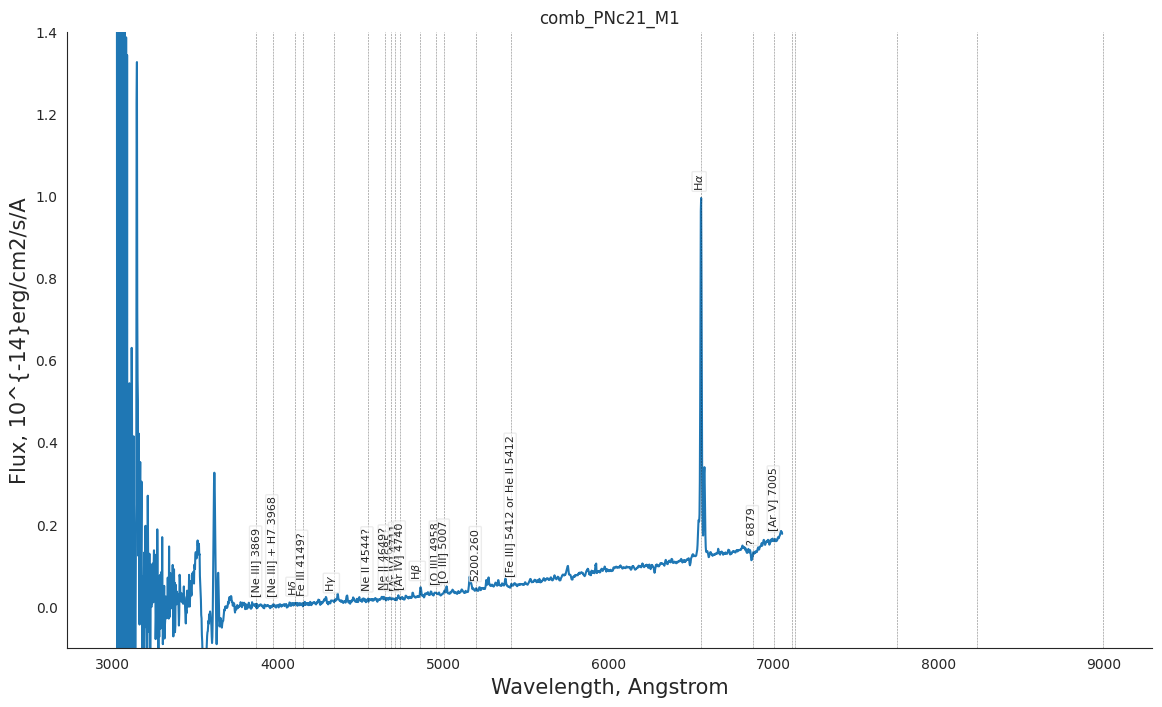

In [20]:
file_name("comb_PNc21_M1.fits", 410, 425, ylim=(-0.1,1.4))

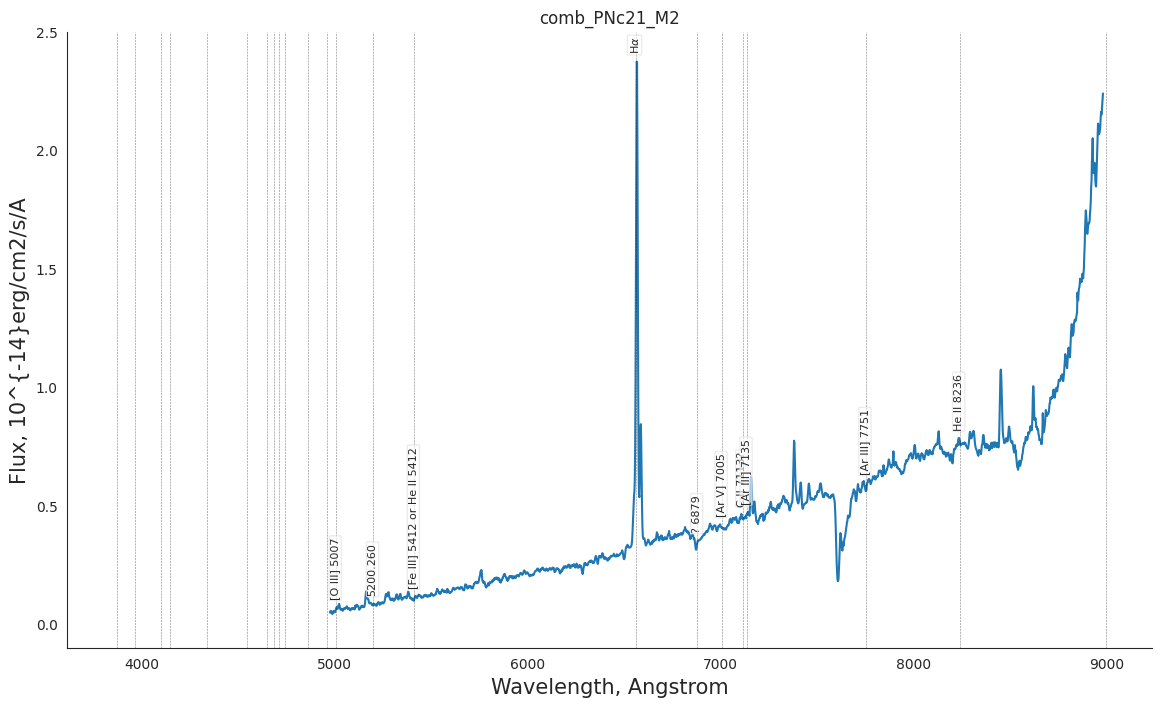

In [21]:
file_name("comb_PNc21_M2.fits", 410, 425, ylim=(-0.1,2.5))

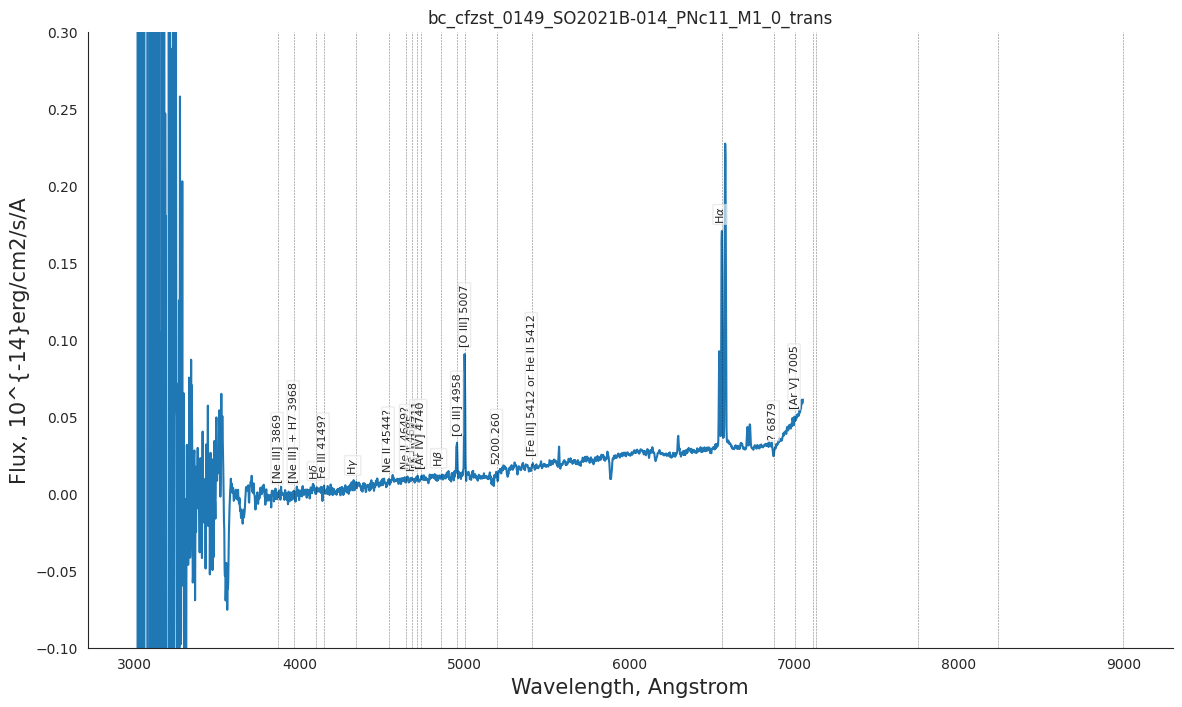

In [22]:
file_name("bc_cfzst_0149_SO2021B-014_PNc11_M1_0_trans.fits", 415,  449, ylim=(-0.1, 0.3))

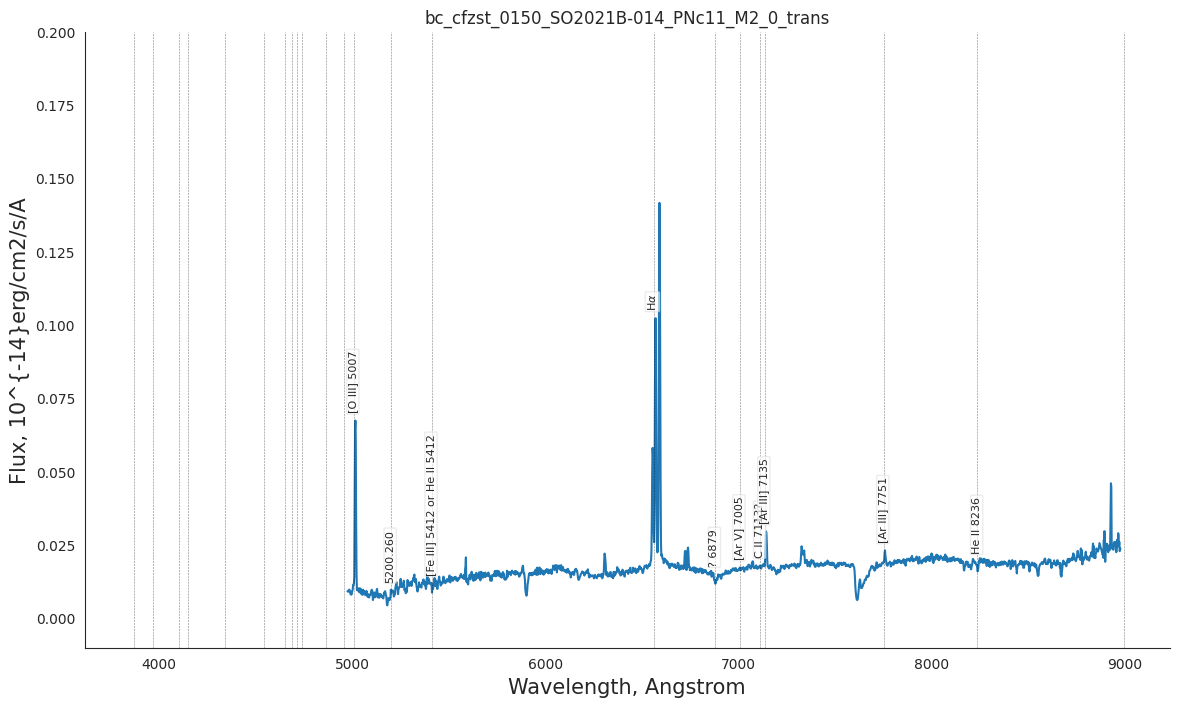

In [23]:
file_name("bc_cfzst_0150_SO2021B-014_PNc11_M2_0_trans.fits", 415, 451, ylim=(-0.01,0.2))

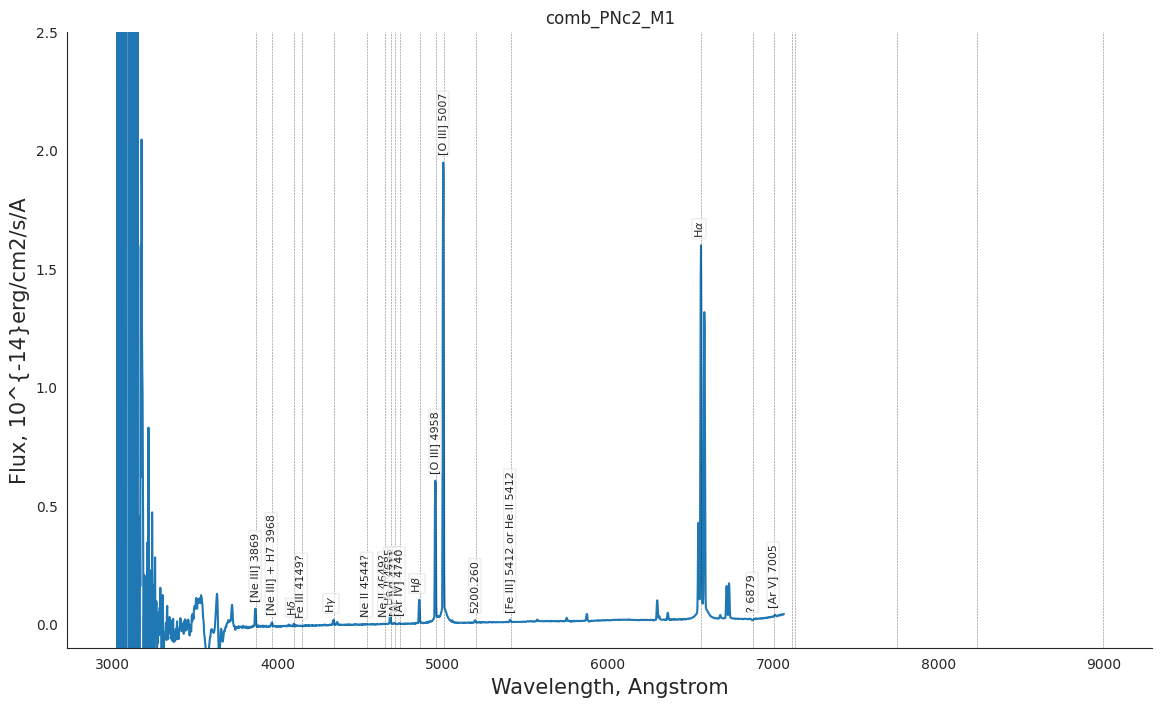

In [21]:
file_name("comb_PNc2_M1.fits", 406, 441, ylim=(-0.1,2.5))

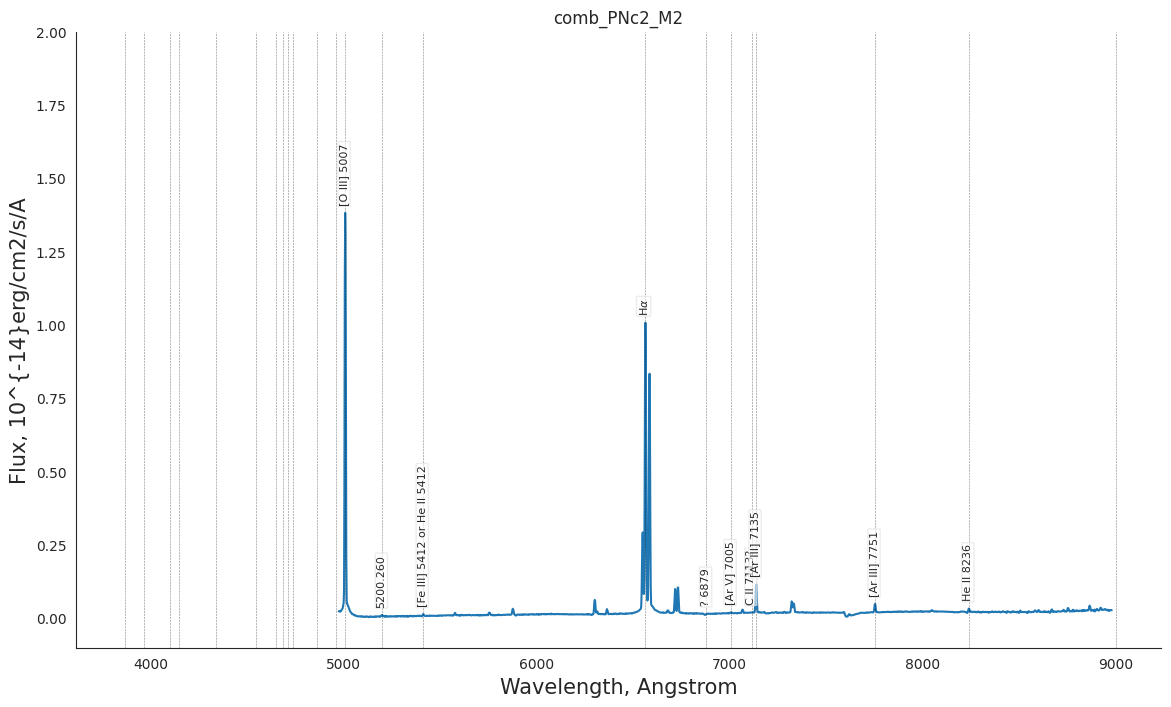

In [26]:
file_name("comb_PNc2_M2.fits", 406, 443, ylim=(-0.1,2.0))


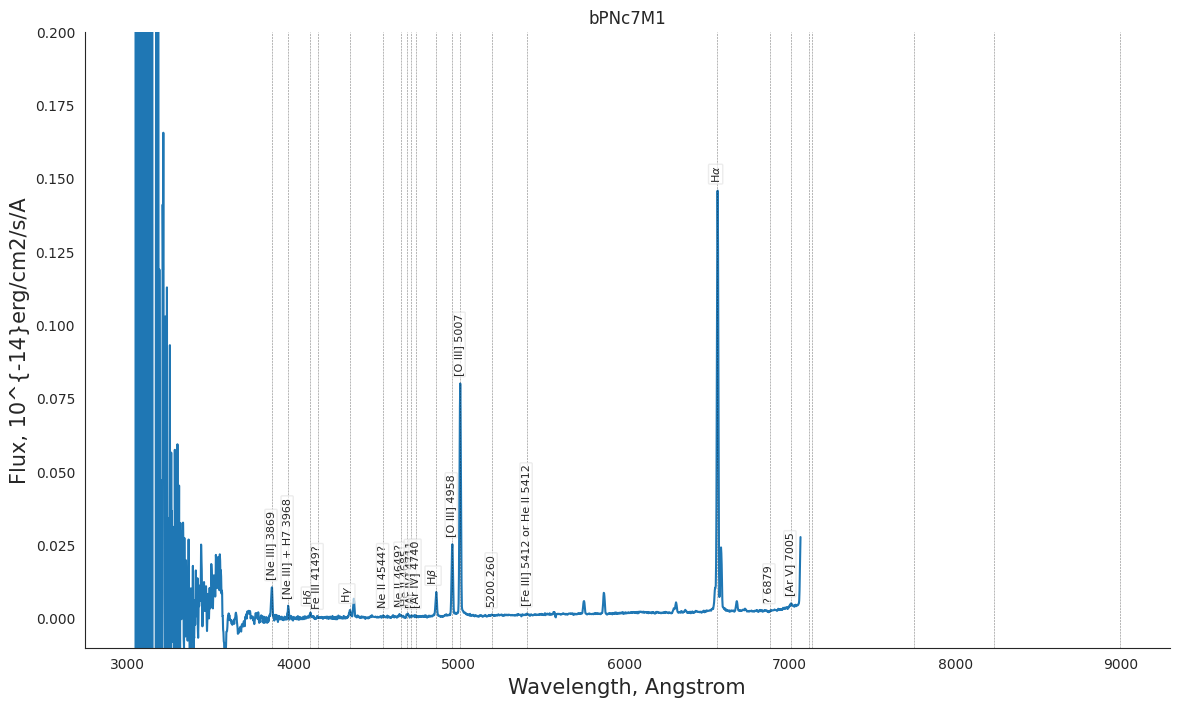

In [23]:
file_name("bPNc7M1.fits", 425, 442, ylim=(-0.01,0.2))